In [6]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives

In [2]:
def my_poly(theta, x):
    # theta0 + theta1*x + theta2*x^2 + ...
    a = jnp.flip(theta)
    y = jnp.polyval(a, x)
    # theta_p*x^p + theta_{p-1}*x^{p-1} + ... + theta_1*x + theta_0
    return y

sigma = 0.3
poly_model_1 = model(sigma, my_poly, theta_dim=2)
poly_model_2 = model(sigma, my_poly, theta_dim=3)
poly_model_5 = model(sigma, my_poly, theta_dim=6)
poly_model_6 = model(sigma, my_poly, theta_dim=7)
poly_model_10 = model(sigma, my_poly, theta_dim=11)
poly_model_11 = model(sigma, my_poly, theta_dim=12)

key = random.PRNGKey(1)
# a = jnp.array([-1, 1, -1/2, 1/3, -1/4, 1/5, -1/6, 1/7, -1/8, 1/9, -1/10, 1/11])
a = jnp.array([-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1])

theta_1 = a[0:2]
theta_2 = a[0:3]
theta_5 = a[0:6]
theta_6 = a[0:7]
theta_10 = a[0:11]
theta_11 = a[0:12]

n_data = 1000
data_1_w = poly_model_1.generate_data(n_data, theta_1, key=random.PRNGKey(10))
data_1_m = poly_model_2.generate_data(n_data, theta_2, key=random.PRNGKey(10))
data_5_w = poly_model_5.generate_data(n_data, theta_5, key=random.PRNGKey(10))
data_5_m = poly_model_6.generate_data(n_data, theta_6, key=random.PRNGKey(10))
data_10_w = poly_model_10.generate_data(n_data, theta_10, key=random.PRNGKey(10))
data_10_m = poly_model_11.generate_data(n_data, theta_11, key=random.PRNGKey(10))


## 1 well

In [3]:
experiment_1_w = experiment(poly_model_1, data_1_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_1_w.run(n_steps=100, step_size=0.00005, lengthscale=0.1)

100%|██████████| 100/100 [00:01<00:00, 56.13it/s]


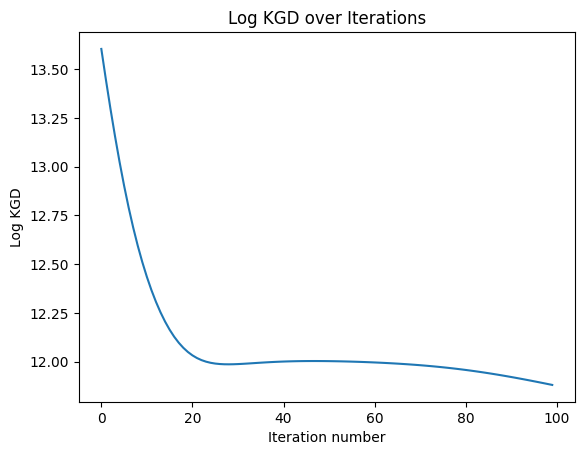

In [4]:
experiment_1_w.plot_KGD()

In [75]:
jnp.mean(experiment_1_w.particles_SVGD, axis=0)

Array([-0.9883857,  1.0052406], dtype=float32)

In [76]:
diagnostic_experiment(experiment_1_w).actual_mmd

Array(0.00016288, dtype=float32)

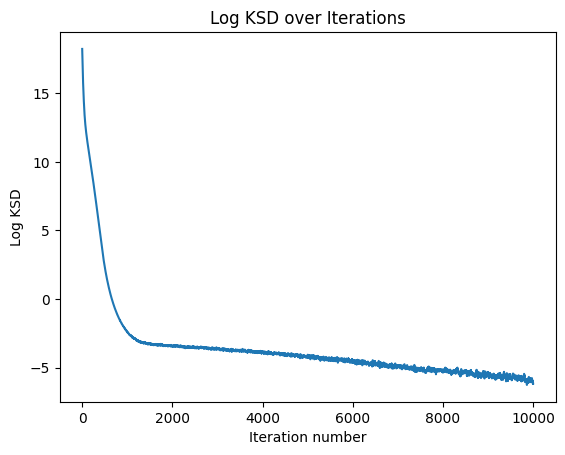

In [77]:
experiment_1_w.plot_KSD()

In [ ]:
diagnostic_experiment_1_w = diagnostic_experiment(experiment_1_w)
all_mmd_values_1_w, actual_mmd_1_w = diagnostic_experiment_1_w.plot_diagnostic(5)

TypeError: 'experiment' object is not callable

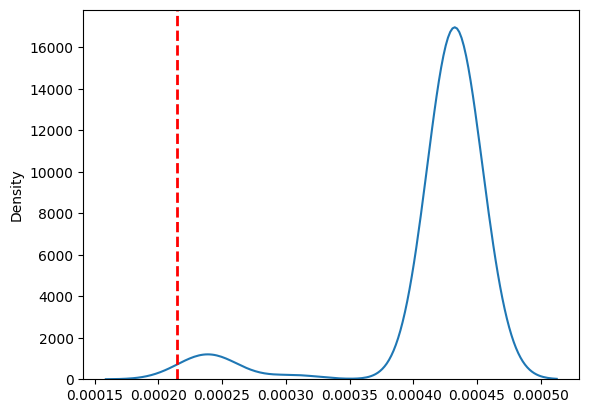

In [61]:
sns.kdeplot(all_mmd_values_1_w)
plt.axvline(actual_mmd_1_w, color='red', linestyle='dashed', linewidth=2)

In [60]:
actual_mmd_1_w

Array(0.0002146, dtype=float32)

In [59]:
all_mmd_values_1_w

Array([0.00043437, 0.00023567, 0.00044448, 0.00022044, 0.00042908,
       0.0004288 , 0.00042573, 0.00023224, 0.00042954, 0.0004231 ,
       0.0002502 , 0.00042789, 0.00042583, 0.00044393, 0.00042874,
       0.00042485, 0.0004359 , 0.00024954, 0.00043407, 0.00043291,
       0.00042966, 0.00043092, 0.00043278, 0.00042321, 0.00042759,
       0.00044135, 0.00042854, 0.0004364 , 0.0004309 , 0.00044331,
       0.00042907, 0.00044679, 0.00043606, 0.00043551, 0.00043046,
       0.00044398, 0.00043037, 0.00042738, 0.00044085, 0.00044673,
       0.00042625, 0.00042592, 0.00044029, 0.00042487, 0.00042803,
       0.00043292, 0.00044361, 0.00043693, 0.0004262 , 0.00043576,
       0.00042492, 0.00042676, 0.00043984, 0.00043447, 0.0004289 ,
       0.00043226, 0.00043167, 0.00042816, 0.00044606, 0.00043427,
       0.00042753, 0.00042886, 0.00042571, 0.00042584, 0.00042337,
       0.00043015, 0.00024854, 0.00043977, 0.00043767, 0.00045026,
       0.00043598, 0.00042574, 0.00042962, 0.0004433 , 0.00042

In [37]:
print(diagnostic_experiment_1_w.all_mmd_values[0:10])

[0.00042283 0.00044001 0.00043579 0.00041106 0.00041505 0.0004152
 0.00041308 0.00043121 0.00042184 0.00041229]


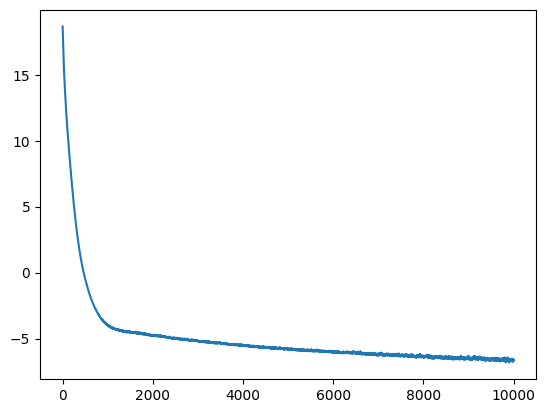

In [36]:
plt.plot(jnp.arange(10000), jnp.log(diagnostic_experiment_1_w.all_history_KSD[0]))

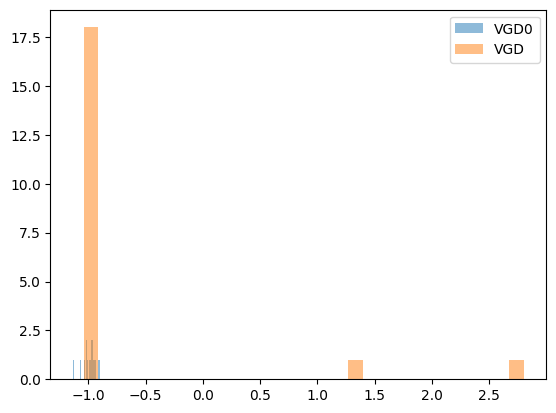

In [72]:
plt.hist(experiment_1_w.particles_VGD[:,0], bins=30, alpha=0.5, label='VGD0')
plt.hist(diagnostic_experiment_1_w.all_particles_VGD[6,:,0], bins=30, alpha=0.5, label='VGD')
plt.legend()

## 1 mis

In [20]:
experiment_1_m = experiment(poly_model_1, data_1_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_1_m.run(n_steps=20000, step_size=0.00005, lengthscale=0.1)

100%|██████████| 20000/20000 [00:24<00:00, 804.95it/s] 


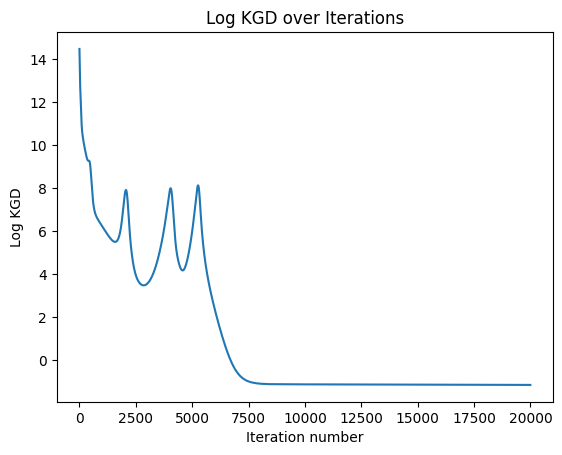

In [21]:
experiment_1_m.plot_KGD()

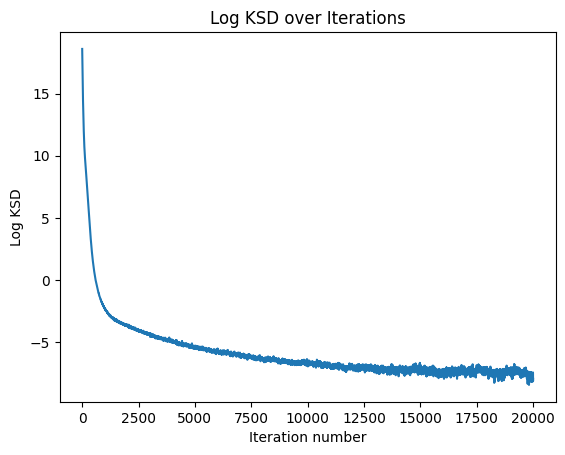

In [22]:
experiment_1_m.plot_KSD()

[[-0.1832884  -1.9243523 ]
 [-0.49775153 -2.2754736 ]]


100%|██████████| 20000/20000 [00:54<00:00, 365.68it/s] 


MMD length scale: 0.83540857
Actual mmd 0.0006082546


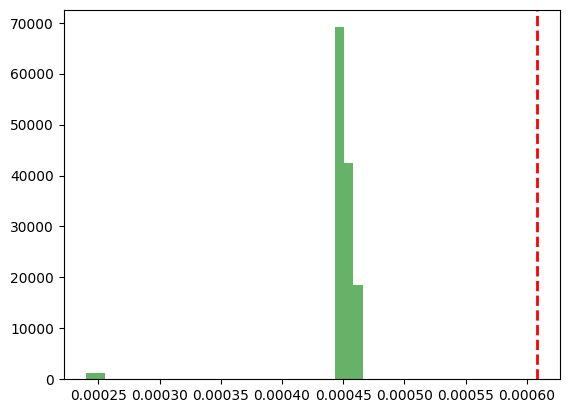

In [24]:
diagnostic_experiment_1_m = diagnostic_experiment(experiment_1_m)
all_mmd_values_1_m, actual_mmd_1_m = diagnostic_experiment_1_m.plot_diagnostic()

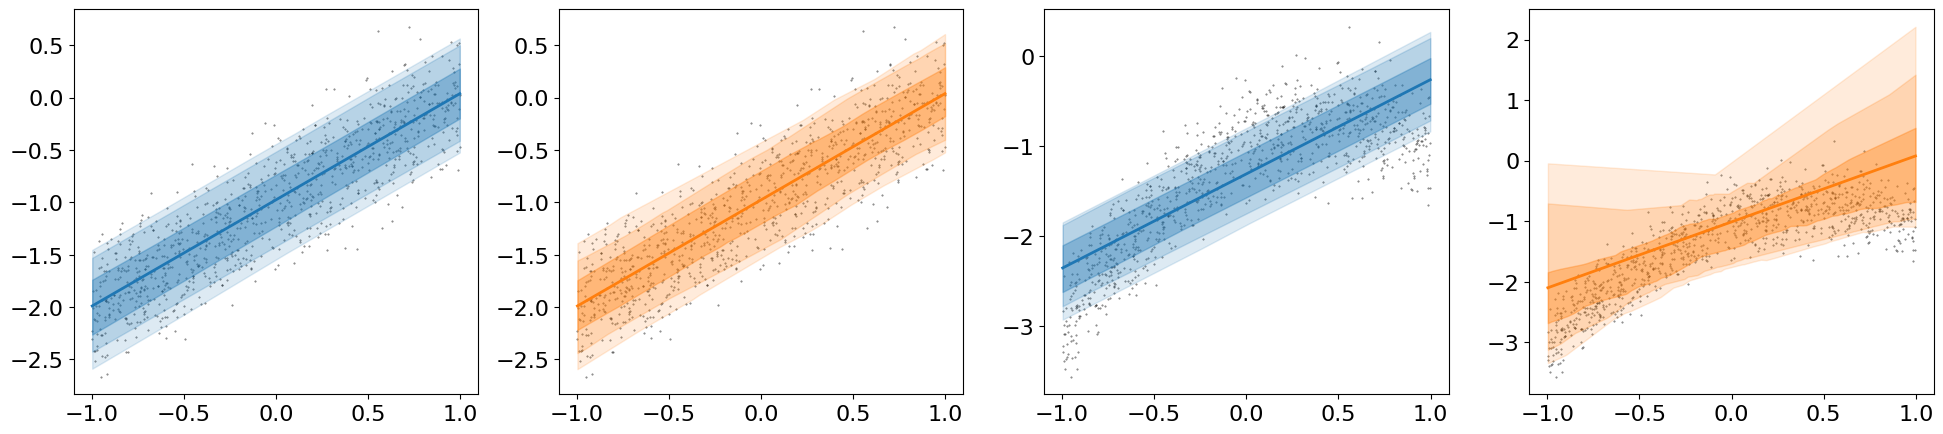

In [32]:
plot_predictives(
    experiment_1_w,
    experiment_1_m, 
    intervals=[50, 80, 90]
)

## 5 well

In [ ]:
experiment_5_w = experiment(poly_model_5, data_5_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_w.run(n_steps=20000, step_size=0.00005, lengthscale=0.1)

In [ ]:
diagnostic_experiment_5_w = diagnostic_experiment(experiment_5_w)
all_mmd_values_5_w, actual_mmd_5_w = diagnostic_experiment_5_w.plot_diagnostic()

## 5 mis

In [ ]:
experiment_5_m = experiment(poly_model_5, data_5_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_5_m.run(n_steps=20000, step_size=0.00005, lengthscale=0.1)

In [ ]:
diagnostic_experiment_5_m = diagnostic_experiment(experiment_5_m)
all_mmd_values_5_m, actual_mmd_5_m = diagnostic_experiment_5_m.plot_diagnostic()

## 10 well

In [ ]:
experiment_10_w = experiment(poly_model_10, data_10_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_w.run(n_steps=20000, step_size=0.00005, lengthscale=0.1)

In [ ]:
diagnostic_experiment_10_w = diagnostic_experiment(experiment_10_w)
all_mmd_values_10_w, actual_mmd_10_w = diagnostic_experiment_10_w.plot_diagnostic()

## 10 mis

In [ ]:
experiment_10_m = experiment(poly_model_10, data_10_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(49))
experiment_10_m.run(n_steps=20000, step_size=0.00005, lengthscale=0.1)

In [ ]:
diagnostic_experiment_10_m = diagnostic_experiment(experiment_10_m)
all_mmd_values_10_m, actual_mmd_10_m = diagnostic_experiment_10_m.plot_diagnostic()